In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split

# Import Numpy
import numpy as np
# For timer
import time
# Import OS
import os

# ==== LOCAL LIBS ====
import ecg_tools_lite as et
import evaluator as eva
import trainer as tr
import models as mod

# Summary-like from Tensorflow
from torchsummary import summary

# wfdb
import wfdb
from wfdb import processing

In [2]:
# What are you trying to do?
create_new_model = True
create_new_res = True

# If create_new_model is True, epochs must have a value
epochs = 10

# Model used:
model_net = mod.ae_sampler

# If create_new_model is False, load_model_name must have a value
load_model_name = 'mmo.pt'
ecg_saved_res = 'res_pt_full_DAE_all_em.npy' #'res_pt_full_2021-3-14_202.npy'

# Normalization option (either option 0 or 1)
norm_option = 2

In [3]:
# # # combine the ultimate noise thing
# ecg_n6 = np.load('all_none_fs1024_en6.npy')
# ecg_00 = np.load('all_none_fs1024_e00.npy')
# ecg_06 = np.load('all_none_fs1024_e06.npy')
# ecg_12 = np.load('all_none_fs1024_e12.npy')
# ecg_18 = np.load('all_none_fs1024_e18.npy')
# ecg_24 = np.load('all_none_fs1024_e24.npy')

# ecg_noisy = np.concatenate((ecg_n6, ecg_00, ecg_06, ecg_12, ecg_18))
# ecg_clean = np.concatenate((ecg_24, ecg_24, ecg_24, ecg_24, ecg_24))
# np.save('all_n618_em', ecg_noisy)
# np.save('all_24-x5_em', ecg_clean)

In [4]:
# Entire noise level runs
# ecg_noisy = torch.from_numpy(np.load('all_noise_em.npy')).cuda().double()
# ecg_clean = torch.from_numpy(np.load('all_clean_em.npy')).cuda().double()
# ecg_noisy = torch.from_numpy(np.load('all_n618_em.npy')).cuda().double()
# ecg_clean = torch.from_numpy(np.load('all_24-x5_em.npy')).cuda().double()

# For single SNR runs
ecg_noisy = torch.from_numpy(np.load('all_none_fs1024_en6.npy')).cuda().double()
ecg_clean = torch.from_numpy(np.load('all_none_fs1024_e24.npy')).cuda().double()

# Acquire original shape
x = ecg_noisy.shape[0]
y = ecg_noisy.shape[2]
z = ecg_noisy.shape[1]

# Reshape
ecg_noisy = torch.reshape( ecg_noisy, (x, y, z))
ecg_clean = torch.reshape( ecg_clean, (x, y, z))

print(f'New shape: {ecg_noisy.shape}')

# == Normalization technique (Norm from -1 to 1)
ecg_noisy = et.norm_sig( ecg_noisy )
ecg_clean = et.norm_sig( ecg_clean )

New shape: torch.Size([5544, 1, 1024])


In [5]:
if create_new_model:
    model = et.train_model( model=model_net,
                            epochs=epochs,
                            ecg_noisy=ecg_noisy,
                            ecg_clean=ecg_clean)
else:
    model = et.load_model( model_name=load_model_name,
                            model=model_net)

train_size[4435] + valid_size[1109]= 5544
same size
Epoch 1 of 10 || time: 75.56 || loss = 0.22624716870267517
Epoch 2 of 10 || time: 70.94 || loss = 0.13054501578056316
Epoch 3 of 10 || time: 71.13 || loss = 0.126167837580461
Epoch 4 of 10 || time: 71.02 || loss = 0.12316973953900782
Epoch 5 of 10 || time: 72.22 || loss = 0.12070093819975658
Epoch 6 of 10 || time: 73.39 || loss = 0.11849190955885938
Epoch 7 of 10 || time: 76.76 || loss = 0.11683355844265421
Epoch 8 of 10 || time: 77.31 || loss = 0.1154424419447604
Epoch 9 of 10 || time: 77.32 || loss = 0.11429487004876178
Epoch 10 of 10 || time: 76.68 || loss = 0.113233479074857
Elapsed time: 742.33, (in mins: 12:22)
Validation dataset has not been used: Available validex set size = 1109
Saved model_2021-3-15_552.pt


In [6]:
# summary( model )

In [7]:
if create_new_model == True or create_new_res == True:
    ecg_res = et.concat_pt_full_cnn(model, ecg_noisy)
    et.get_local_time()
else:
    ecg_res = np.load( ecg_saved_res )

ecg_res = ecg_res.flatten()

Result size: (2000, 1, 1024)
Result size: (2000, 1, 1024)
Result size: (1000, 1, 1024)
Result size: (544, 1, 1024)
Complete shape is: (5544, 1, 1024)
Filename: res_pt_full_2021-3-15_552


In [8]:
ecg_clean = ecg_clean.cpu().numpy().flatten()
ecg_noisy = ecg_noisy.cpu().numpy().flatten()

In [9]:
ecg_res2 = et.realign_starting(ecg_res, ecg_clean.flatten())

Diff: -0.27553876938158084
-0.6257309941520464 - -0.6257309941520464
-0.6257309941520464 - -0.6257309941520464


<Figure size 1440x576 with 0 Axes>

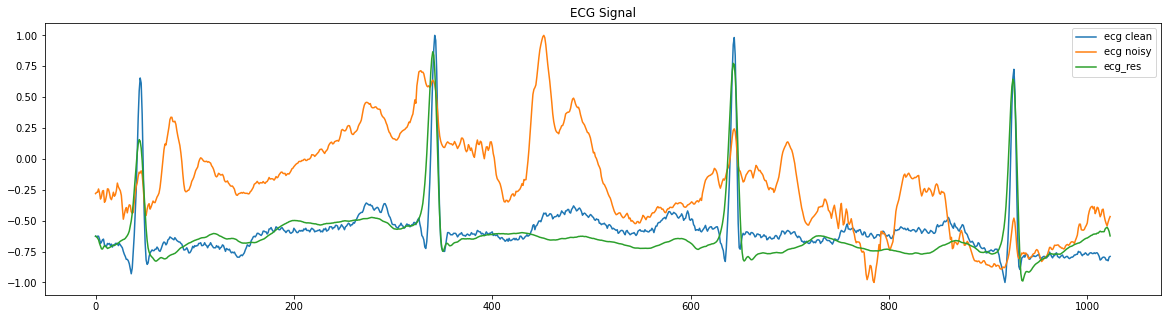

In [10]:
et.ecg_plot( [ecg_clean, ecg_noisy, ecg_res2], ['ecg clean', 'ecg noisy', 'ecg_res'], index=0)

In [11]:
ecg_res2.shape
ecg_clean.flatten().shape

(5677056,)

In [12]:
ecg_noisy = torch.from_numpy(np.load('all_none_fs1024_en6.npy')).cuda().double()
ecg_noisy = torch.reshape( ecg_noisy, (x, y, z))
ecg_noisy = et.norm_sig( ecg_noisy )

with torch.cuda.device(0):
    evals = eva.get_eval_metrics(ecg_clean=ecg_clean.flatten(), ecg_noisy=ecg_noisy.flatten(), ecg_denoised=ecg_res)

SNR Improvement: 3.5470740868581707
RMSE: 0.3413729791944628
PRD: 6.218781338251766
Elapsed time: 351.27, (in mins: 5:51)


In [13]:
ecg_noisy = torch.from_numpy(np.load('all_none_fs1024_e00.npy')).cuda().double()
ecg_noisy = torch.reshape( ecg_noisy, (x, y, z))
ecg_noisy = et.norm_sig( ecg_noisy )

with torch.cuda.device(0):
    evals = eva.get_eval_metrics(ecg_clean=ecg_clean.flatten(), ecg_noisy=ecg_noisy.flatten(), ecg_denoised=ecg_res)

SNR Improvement: 2.6606983797174792
RMSE: 0.3413729791944628
PRD: 6.218781338251766
Elapsed time: 355.48, (in mins: 5:55)


In [14]:
ecg_noisy = torch.from_numpy(np.load('all_none_fs1024_e06.npy')).cuda().double()
ecg_noisy = torch.reshape( ecg_noisy, (x, y, z))
ecg_noisy = et.norm_sig( ecg_noisy )

with torch.cuda.device(0):
    evals = eva.get_eval_metrics(ecg_clean=ecg_clean.flatten(), ecg_noisy=ecg_noisy.flatten(), ecg_denoised=ecg_res)

SNR Improvement: 0.5346476469457362
RMSE: 0.3413729791944628
PRD: 6.218781338251766
Elapsed time: 345.17, (in mins: 5:45)


In [15]:
ecg_noisy = torch.from_numpy(np.load('all_none_fs1024_e12.npy')).cuda().double()
ecg_noisy = torch.reshape( ecg_noisy, (x, y, z))
ecg_noisy = et.norm_sig( ecg_noisy )

with torch.cuda.device(0):
    evals = eva.get_eval_metrics(ecg_clean=ecg_clean.flatten(), ecg_noisy=ecg_noisy.flatten(), ecg_denoised=ecg_res)

SNR Improvement: -3.806362264261778
RMSE: 0.3413729791944628
PRD: 6.218781338251766
Elapsed time: 349.26, (in mins: 5:49)


In [16]:
ecg_noisy = torch.from_numpy(np.load('all_none_fs1024_e18.npy')).cuda().double()
ecg_noisy = torch.reshape( ecg_noisy, (x, y, z))
ecg_noisy = et.norm_sig( ecg_noisy )

with torch.cuda.device(0):
    evals = eva.get_eval_metrics(ecg_clean=ecg_clean.flatten(), ecg_noisy=ecg_noisy.flatten(), ecg_denoised=ecg_res)

SNR Improvement: -12.09574013960588
RMSE: 0.3413729791944628
PRD: 6.218781338251766
Elapsed time: 344.72, (in mins: 5:44)


In [17]:
# with torch.cuda.device(0):
#     evals = eva.get_eval_metrics(ecg_clean=ecg_clean.flatten(), ecg_noisy=ecg_noisy.flatten(), ecg_denoised=ecg_res2)

In [18]:
# with torch.cuda.device(0):
#     evals = eva.get_eval_metrics(ecg_clean=ecg_clean.flatten(), ecg_noisy=ecg_noisy.flatten(), ecg_denoised=ecg_res)